In [1]:
%load_ext autoreload

In [2]:
%autoreload

import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyinla.model import *
from pyinla.raster import *
from pyinla.spde import *
from pyinla.utils import *

In [3]:
libraster = importr("raster")
libsp = importr("sp")

In [4]:
gambia = ro.r('library("geoR"); data(Gambia); gambia')

R[write to console]: --------------------------------------------------------------
 Analysis of Geostatistical Data
 For an Introduction to geoR go to http://www.leg.ufpr.br/geoR
 geoR version 1.9-2 (built on 2022-08-09) is now loaded
--------------------------------------------------------------




In [5]:
agg = gambia.groupby(["x", "y"])

In [6]:
total = agg["pos"].size()
positive = agg["pos"].sum()
prevalence = positive / total

In [7]:
x, y = list(zip(*agg.groups.keys()))

In [8]:
d = dict(
    x=np.array(x),
    y=np.array(y),
    total=total.values,
    positive=positive.values,
    prevalence=prevalence.values,
)

In [9]:
gdf = gpd.GeoDataFrame.from_dict(
    d, geometry=gpd.points_from_xy(x=x, y=y), crs="+proj=utm +zone=28"
).to_crs("+proj=longlat +datum=WGS84")
geom = gdf.geometry.to_crs("+proj=longlat +datum=WGS84")
gdf["long"] = geom.centroid.x
gdf["lat"] = geom.centroid.y

/var/folders/l1/xkqt8tg56t325lgp9ctmslwm0000gn/T/ipykernel_99345/3175676654.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["long"] = geom.centroid.x
/var/folders/l1/xkqt8tg56t325lgp9ctmslwm0000gn/T/ipykernel_99345/3175676654.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = geom.centroid.y


In [10]:
m = folium.Map(location=(gdf.lat[0], gdf.long[0]))
for i in range(len(gdf)):
    folium.Circle(radius=50, location=(gdf.lat[i], gdf.long[i])).add_to(m)
m

In [11]:
raster = ro.r('library(raster); getData(name = "alt", country = "GMB", mask = TRUE)')
alt = raster_extract(raster, gdf[["long", "lat"]])
gdf["alt"] = alt

/opt/homebrew/Caskroom/miniconda/base/envs/main/lib/python3.10/site-packages/numpy/core/numeric.py:2382: RuntimeWarning: invalid value encountered in multiply
  x = x * ones_like(cond)


In [12]:
coo = gdf[["long", "lat"]]
mesh = mesh_2d(coo, max_edge=[0.1, 5], cutoff=0.01)

<AxesSubplot: >

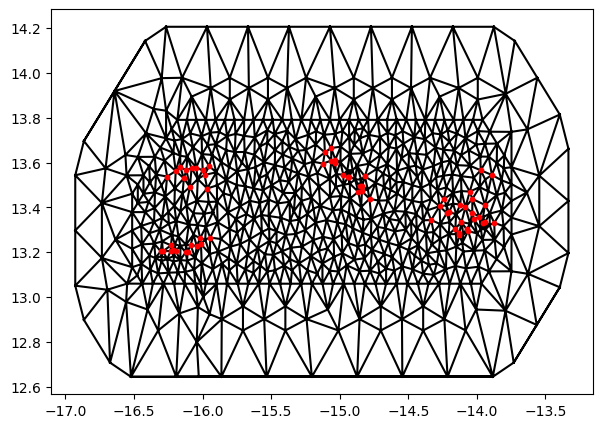

In [13]:
mesh.plot(figsize=(7, 5))

In [14]:
ra = raster_aggregate(raster, fact=5, fun="mean")
dp = raster_to_points(ra)
coop = dp[:, :2]
Ap = make_projection_matrix(mesh=mesh, loc=coop)

In [15]:
A = make_projection_matrix(mesh=mesh, loc=coo)

In [16]:
spde = spde2_matern(mesh)
indexs = spde.make_index("s")

In [17]:
stk_e = inla_stack(
    tag="est",
    data=dict(y=gdf.positive, numtrials=gdf.total),
    A=A,
    effects=dict(b0=1, altitude=gdf.alt),
    s=indexs,
)
stk_p = inla_stack(
    tag="pred",
    data=dict(y=np.nan, numtrials=np.nan),
    A=Ap,
    effects=dict(b0=1, altitude=dp[:, 2]),
    s=indexs,
)
stk_full = combine_stacks(stk_e, stk_p)

In [18]:
formula = "y ~ 0 + b0 + altitude + f(s, model = spde)"

In [19]:
res = inla(
    formula,
    data=convert_r2py(stack_data(stk_full)) | dict(spde=spde.spde),
    family="binomial",
    n_trials="numtrials",
    control_family=dict(link="logit"),
    control_predictor=dict(compute=True, link=1, A=stack_A(stk_full)),
)

/opt/homebrew/Caskroom/miniconda/base/envs/main/lib/python3.10/site-packages/numpy/core/numeric.py:2382: RuntimeWarning: invalid value encountered in multiply
  x = x * ones_like(cond)


In [20]:
res

Time used:
     = 1.73,  = 0.452,  = 0.0249,  = 2.21 
Fixed effects:
           mean   sd 0.025quant 0.5quant 0.975quant   mode kld
b0       -0.190 0.49     -1.048   -0.227      0.911 -0.278   0
altitude -0.012 0.01     -0.032   -0.012      0.009 -0.012   0

Random effects:
  Name	  Model
    s SPDE2 model

Model hyperparameters:
              mean    sd 0.025quant 0.5quant 0.975quant  mode
Theta1 for s -4.00 0.286      -4.56    -4.00      -3.43 -4.00
Theta2 for s  2.63 0.365       1.91     2.64       3.35  2.65

Marginal log-Likelihood:  -216.11 
 is computed 
Posterior summaries for the linear predictor and the fitted values are computed
(Posterior marginals needs also 'control.compute=list(return.marginals.predictor=TRUE)')


In [27]:
pd.DataFrame.from_dict(convert_r2py(res.get_summary_type("fitted.values")))

,mean,sd,0.025quant,0.5quant,0.975quant,mode
0,0.499609,0.080439,0.343279,0.499550,0.656260,0.499409
1,0.325282,0.053082,0.227624,0.323154,0.434961,0.318711
2,0.366094,0.078077,0.225331,0.361955,0.530069,0.353235
3,0.318244,0.085193,0.170388,0.312010,0.500677,0.297985
4,0.418263,0.070957,0.285529,0.416167,0.562625,0.411624
...,...,...,...,...,...,...
1604,0.029187,1.176928,-2.318328,0.026776,2.386527,0.021603
1605,-0.098031,1.176362,-2.493190,-0.080973,2.192190,-0.056690
1606,0.057917,1.160178,-2.238365,0.053010,2.380043,0.044100
1607,0.018299,1.175592,-2.341994,0.012691,2.406757,0.006500
